New version of the plotbox function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl

import warnings
warnings.filterwarnings("ignore")

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [39]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils, boxplot

In [40]:
from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import processing
from tools_for_VAE.boxplot import boxplot_func

ImportError: cannot import name 'boxplot_func'

# Loading the trained VAE

In [3]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v16/bis/mse/',6, folder= True) #v15/bis # v12/bis2

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v16/mse/',10, folder = True)#2508#v13/bis/ #v9/bis2

Instructions for updating:
Colocations handled automatically by placer.


# Load data

In [15]:
data_dir = "/sps/lsst/users/barcelin/data/single_galaxies/28/miscenter/test/"
root = 'galaxies_blended_20191024'

In [16]:
images = np.load(data_dir+'galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

In [17]:
test_sample = [data_dir+'galaxies_blended_20191024_0_images.npy']

In [65]:
data_dir_center = "/sps/lsst/users/barcelin/data/single_galaxies/28/test/"
root_center = 'galaxies_isolated_20191022'
test_sample_center = [data_dir_center+'galaxies_isolated_20191022_0_images.npy']

# Parameters to fix

In [19]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

bands_r = [6]
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

batch_size = 100

In [20]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

## load LSST Euclid center results

In [18]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [66]:
df_lsst_euclid_center = pd.read_csv('data/df_deb_lsst_euclid.csv', encoding = 'utf-8')

## LSST + Euclid all filters

Test VAE_processing for LSST and Euclid all band-pass filters

In [22]:
batch_size = 100

df_lsst_euclid = results_processing.processing(vae_lsst_euclid_conv,
                                                       data_dir,
                                                       root,
                                                       test_sample[0],
                                                       bands_lsst_euclid,
                                                       6,
                                                       stamp_size,  
                                                       batch_size,
                                                       PSF, 
                                                       pix_scale_lsst,
                                                       n_years = 5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
error for galaxy 14433
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
error for galaxy 22053
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
error for galaxy 36818
93
94
95
96
97
98
99

(10000, 2, 2)


In [23]:
df_lsst_euclid.to_csv('data/df_deb_lsst_euclid_miscenter.csv')

In [24]:
df_lsst_euclid = pd.read_csv('data/df_deb_lsst_euclid_miscenter.csv', encoding = 'utf-8')

### Shape plots

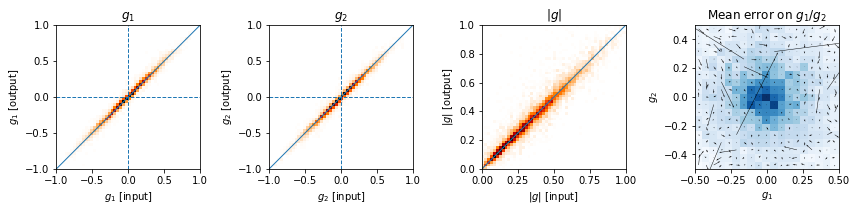

In [25]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e2_in'], df_lsst_euclid['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(df_lsst_euclid['e_in'], df_lsst_euclid['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], values=df_lsst_euclid['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_lsst_euclid['e1_in'], df_lsst_euclid['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

# Delta WL parameters

## As function of SNR

In [76]:
df_plot = pd.concat([df_lsst_euclid], ignore_index=True)#df_lsst_euclid_center,
df_plot['exp'] = [1]*10000# + [2]*10000

In [77]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
Unnamed: 0                    10000 non-null int64
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null flo

In [78]:
reload(boxplot)

<module 'tools_for_VAE.boxplot' from '../../scripts/tools_for_VAE/tools_for_VAE/boxplot.py'>

In [79]:
df_plot = df_plot.dropna(axis = 1, how = 'all')

In [80]:
df_plot

,Unnamed: 0,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,...,e_in,e_out,e_error,e_in_obs,e_out_obs,e_obs_error,mag_in,mag_out,delta_mag,exp
0,0,1,13.862065,0.010834,0.6798,1.737687,-0.036937,-0.051531,28.631095,-0.029491,...,0.063402,0.224202,0.160800,0.031275,0.083164,0.051889,26.882255,26.940510,0.058255,1
1,1,1,9.935771,0.007382,1.3183,1.960772,-0.323186,-0.600951,28.773098,-1.588396,...,0.682342,0.289051,-0.393291,0.281410,0.183271,-0.098139,27.024509,26.996956,-0.027553,1
2,2,1,78.128952,0.052243,0.4872,2.155534,0.215846,0.164230,26.438238,-1.256599,...,0.271222,0.251756,-0.019466,0.215739,0.210008,-0.005731,24.689304,24.699236,0.009932,1
3,3,1,72.117854,0.058159,2.3700,1.734574,0.443703,-0.286503,26.795541,-4.928309,...,0.528163,0.422090,-0.106073,0.184908,0.150129,-0.034779,25.047249,25.005575,-0.041674,1
4,4,1,29.526335,0.022994,0.7312,1.675584,0.225083,-0.403308,27.893187,0.253033,...,0.461865,0.550822,0.088957,0.161659,0.174921,0.013263,26.143967,26.161232,0.017265,1
5,5,1,27.494768,0.020948,0.8544,1.846871,0.487035,0.490139,27.850206,-0.022360,...,0.690970,0.673992,-0.016978,0.323970,0.326848,0.002878,26.101000,26.134790,0.033791,1
6,6,1,100.987380,0.066233,0.4493,2.030441,-0.658692,-0.149067,26.353247,-0.675359,...,0.675349,0.678029,0.002680,0.426831,0.419796,-0.007036,24.604034,24.588099,-0.015935,1
7,7,1,67.923865,0.049036,0.4553,1.889606,-0.003799,0.169222,26.854807,-0.184805,...,0.169265,0.174128,0.004863,0.115167,0.119811,0.004644,25.105592,25.125889,0.020297,1
8,8,1,1098.342263,0.966715,0.1600,1.976767,0.196415,0.061086,23.389370,-4.044414,...,0.205694,0.282351,0.076656,0.129754,0.140140,0.010386,21.641944,21.608986,-0.032958,1
9,9,1,19.762037,0.014703,0.9531,1.762033,0.365216,-0.264388,28.269659,-0.214761,...,0.450870,0.360182,-0.090689,0.202696,0.163297,-0.039399,26.520446,26.505520,-0.014926,1


In [81]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
Unnamed: 0              10000 non-null int64
nb_blended_gal          10000 non-null int64
SNR                     10000 non-null float64
SNR_peak                10000 non-null float64
redshift                10000 non-null float64
moment_sigma            10000 non-null float64
e1                      10000 non-null float64
e2                      10000 non-null float64
mag                     10000 non-null float64
mag_ir                  10000 non-null float64
closest_x               10000 non-null float64
closest_y               10000 non-null float64
closest_redshift        10000 non-null float64
closest_moment_sigma    10000 non-null float64
closest_e1              10000 non-null float64
closest_e2              10000 non-null float64
closest_mag             10000 non-null float64
closest_mag_ir          10000 non-null float64
e1_in                   9997 non-null float64
e1_o

In [82]:
np.min(df_plot['SNR_peak']), np.max(df_plot['SNR_peak'])

(0.0018917554240822766, 8.161338964541098)

In [83]:
np.min(df_plot['SNR']), np.max(df_plot['SNR'])

(3.023691485149759, 6821.523481263411)

9997
[1]
0 1


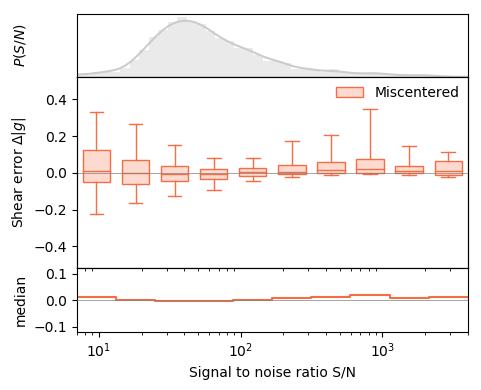

In [84]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot.boxplot_func(df_plot, 
              x = 'SNR', y = 'e_error', z = 'exp',
              xlim = (7, 4000.),
              ylim = (-0.52, 0.52), 
              ylim2 = (-0.12, 0.12), 
              x_scale = 'log',
              legend = ['Miscentered'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.20,0.15]),#0.35,
              nbins = 10)


9997
[1]
0 1


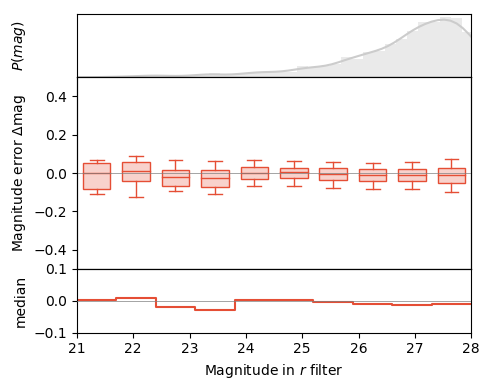

In [85]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot.boxplot_func(df_plot, 
              x = 'mag', y = 'delta_mag', z = 'exp',
              xlim = (21, 28),
              ylim = (-0.5, 0.5),
              ylim2 = (-0.1, 0.1),
              x_scale = 'linear',
              legend = ['LSST + Euclid'],
              x_label='Magnitude in $r$ filter', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/mag_mag_vae_2.pdf')

In [19]:
df_plot = pd.concat([df_lsst, df_lsst_euclid], ignore_index=True)
df_plot['exp'] = [1]*10000 + [2]*10000

[1 2]
0 1
1 2


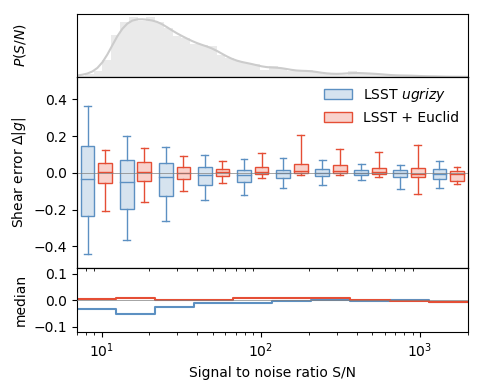

In [27]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.52, 0.52), 
              ylim2 = (-0.12, 0.12), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/e_vae_snr_2.pdf')

[1 2]
0 1
1 2


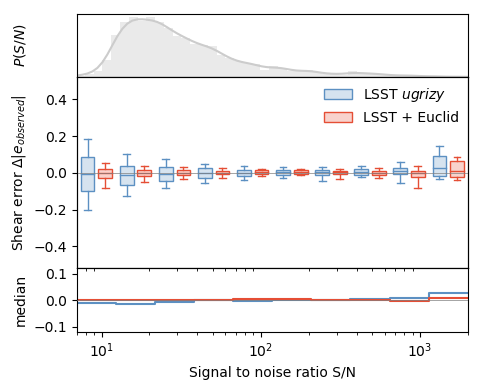

In [28]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_obs_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.52, 0.52), 
              ylim2 = (-0.12, 0.12), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |e_{observed}|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/e_vae_snr_2.pdf')

[1 2]
0 1
1 2


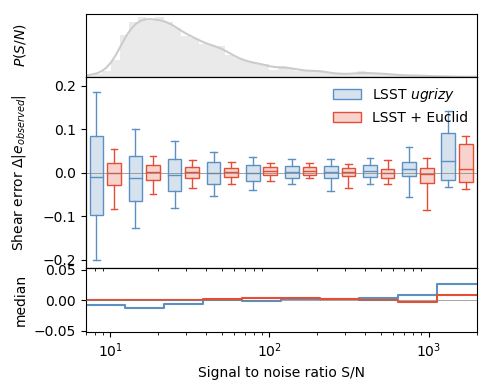

In [29]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_obs_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.22, 0.22), 
              ylim2 = (-0.052, 0.052), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |e_{observed}|$',
              y_label_hist='$P(S/N)$',
              y_label_2 = 'median',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/e_vae_snr_2.pdf')

[1 2]
0 1
1 2


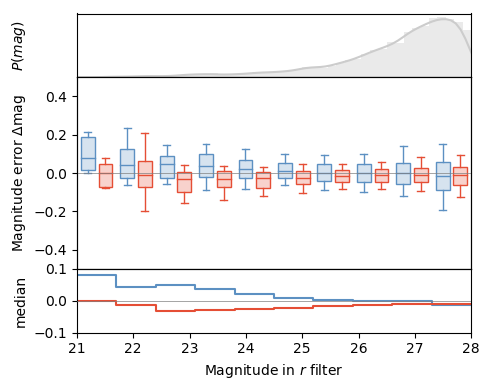

In [31]:
fig, median_mag, q1_mag, q3_mag, whislo_mag, whishi_mag = boxplot(df_plot, 
              x = 'SNR', y = 'delta_mag', z = 'exp',
              xlim = (21, 28),
              ylim = (-0.5, 0.5),
              ylim2 = (-0.1, 0.1),
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST + Euclid'],
              x_label='Magnitude in $r$ filter', 
              y_label = 'Magnitude error $\Delta$mag',
              y_label_hist='$P(mag)$',
              y_label_2 = 'median',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
              nbins = 10)

#fig.savefig('figures/mag_mag_vae_2.pdf')

In [53]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = median_shear
df_stat['q1_shear'] = q1_shear
df_stat['q3_shear'] = q3_shear
df_stat['whislo_shear'] = whislo_shear
df_stat['whishi_shear'] = whishi_shear
df_stat['median_mag'] = median_mag
df_stat['q1_mag'] = q1_mag
df_stat['q3_mag'] = q3_mag
df_stat['whislo_mag'] = whislo_mag
df_stat['whishi_mag'] = whishi_mag
df_stat['stats_names'] = ['r band']*10 + ['LSST']*10 + ['LSST Euclid']*10

In [66]:
param = 'median_shear'
x =4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.08148673592081422, -0.021777450019809713, -0.004646400081478825]
improvement between each exp: [3.7417941883319834, 4.686951110090058]


In [67]:
param = 'q1_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.3846431402405489, -0.14339668406398262, -0.04774976269913507]
improvement between each exp: [2.682371232998134, 3.00308684186571]


In [68]:
param = 'q3_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.05605128134437953, 0.08248637884056492, 0.029987731738951855]
improvement between each exp: [0.6795216632399287, 2.750670826277307]


In [69]:
param = 'whislo_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.7232608413441084, -0.29437192715456995, -0.13841826222057566]
improvement between each exp: [2.456962687764502, 2.1266841703696238]


In [70]:
param = 'whishi_shear'
x = 4 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.25273168545003033, 0.20463371751828804, 0.08946267180449145]
improvement between each exp: [1.235044197579237, 2.2873642536128065]


In [59]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.005875948746374172, 0.024837896282496594, 0.011948886416220005]
improvement between each exp: [-0.23657191734531022, 2.0786787502457478]


In [60]:
param = 'q1_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.08181082392928671, -0.03570730136353202, -0.03931890248070341]
improvement between each exp: [2.291151131707768, 0.908145932635229]


In [37]:
param = 'q3_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.07498771778973266, 0.10417360216169129, 0.07158971307643328]
improvement between each exp: [0.7198341636813302, 1.4551476418192875]


In [38]:
param = 'whislo_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.159252965044307, -0.08878044120363, -0.08005287060420248]
improvement between each exp: [1.7937843390419597, 1.1090225813709842]


In [39]:
param = 'whishi_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.1629248613056629, 0.1606000103707291, 0.12570376026940264]
improvement between each exp: [1.0144760322839774, 1.277607050310495]
